In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import time
from datetime import date, datetime
from dateutil import relativedelta

import requests
from bs4 import BeautifulSoup
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('matplotlibrc')

## scrape

In [2]:
start_date = datetime(2022, 1, 1)
end_date   = datetime.now()

Run `navigator.userAgent` in Chrome developer console to get User-Agent

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36'}

this_date = start_date
dftables = []
while this_date <= end_date:
    url = 'https://checkee.info/main.php?dispdate=' + this_date.strftime('%Y-%m')
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    for table in soup.find_all('table'):
        if table.find_all('tr')[0].find_all('td')[0].get_text(strip=True) == 'Update':
            break
    raw_data = [[td.get_text(strip=True) for td in tr.find_all('td')[1:-1]] for tr in table.find_all('tr')]
    dftables.append(pd.DataFrame(raw_data[1:], columns=raw_data[0]))
    print(this_date.strftime('%Y-%m') + ': ' + f'{len(raw_data)-1} cases')

    time.sleep(1)
    this_date += relativedelta.relativedelta(months=1)
data = pd.concat(dftables, ignore_index=True)
print(f'total: {len(data)} cases')

2022-01: 89 cases
2022-02: 79 cases
2022-03: 77 cases
2022-04: 179 cases
2022-05: 252 cases


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


2022-06: 311 cases


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


2022-07: 128 cases


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


2022-08: 141 cases
2022-09: 142 cases
2022-10: 109 cases
2022-11: 15 cases
total: 1522 cases


In [4]:
data

,ID,Visa Type,Visa Entry,US Consulate,Major,Status,Check Date,Complete Date,Waiting Day(s)
0,visa,B2,Renewal,GuangZhou,Chemistry,Clear,2022-01-04,2022-03-01,56
1,YZ,H1,New,Ottawa,CS,Clear,2022-01-04,2022-02-18,45
2,cksteven,F1,Renewal,Ottawa,Psychology (CS undergrad),Clear,2022-01-04,2022-03-02,57
3,0104,B2,New,BeiJing,N/A,Reject,2022-01-04,2022-01-14,10
4,YF,H1,Renewal,Others,Computer Engineering,Clear,2022-01-04,2022-02-22,49
...,...,...,...,...,...,...,...,...,...
1517,ењЂзВєж±ВињЗ,H1,Renewal,Ottawa,N/A,Pending,2022-11-03,0000-00-00,4
1518,йШњеЊЈеУ•,H1,New,ShangHai,CS,Pending,2022-11-04,0000-00-00,3
1519,ж±Вж±ВдЇЖ,H1,New,Toronto,Data Visualization,Pending,2022-11-04,0000-00-00,3
1520,ењЂжРЮењЂињЗ,B1,New,Toronto,N/A,Pending,2022-11-06,0000-00-00,1


## plot

In [9]:
ref_check_date = datetime(2022, 1, 1)

groups = ['F1', 'J1']
alphas = [0.8 , 0.4 ]
#groups = ['H1']
#alphas = [0.8]

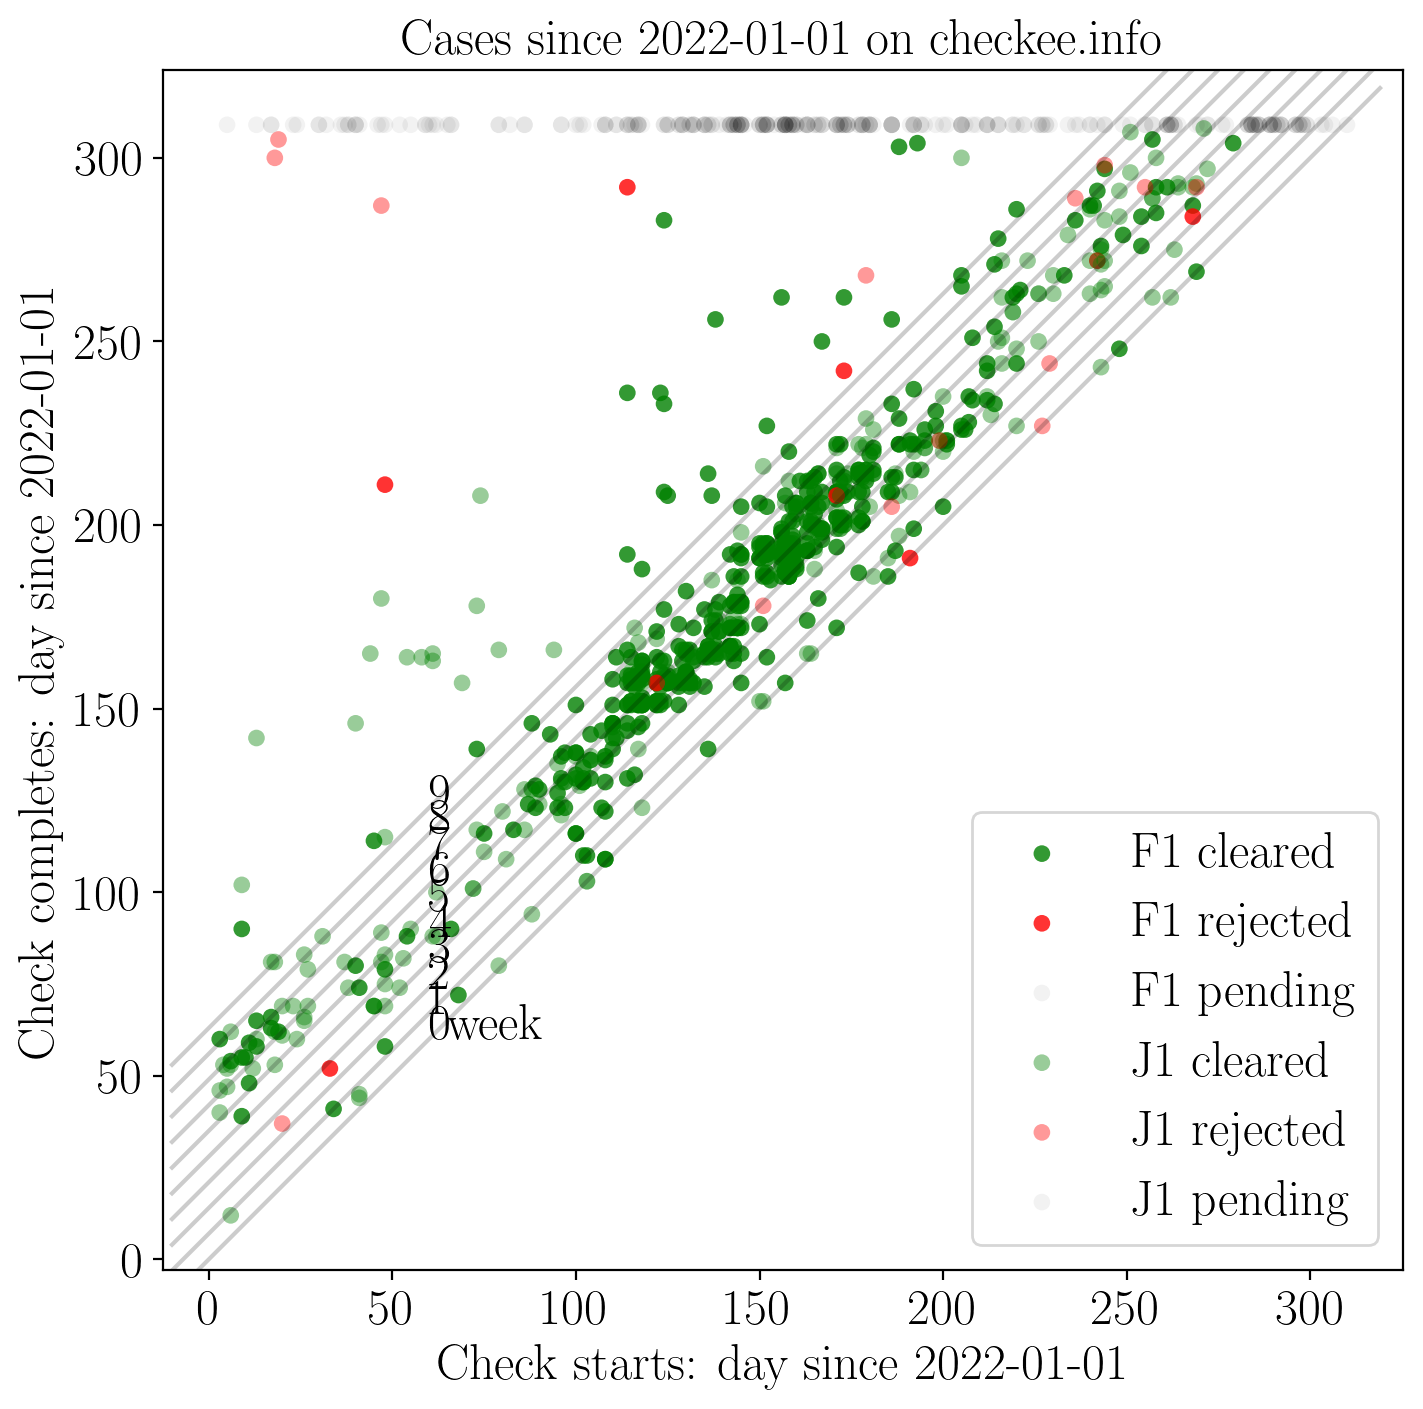

In [10]:
fig, ax = plt.subplots(figsize=(8,8))

for ig, group in enumerate(groups):
    
    subdata = data[(data['Visa Type']==group)&(data['Status']=='Clear')]
    x = [dt.days for dt in (pd.to_datetime(subdata['Check Date']) - ref_check_date)]
    y = [dt.days for dt in (pd.to_datetime(subdata['Complete Date']) - ref_check_date)]
    ax.scatter(x, y, fc='green', ec=None, alpha=alphas[ig], label=(group+' cleared'))
    
    subdata = data[(data['Visa Type']==group)&(data['Status']=='Reject')]
    x = [dt.days for dt in (pd.to_datetime(subdata['Check Date']) - ref_check_date)]
    y = [dt.days for dt in (pd.to_datetime(subdata['Complete Date']) - ref_check_date)]
    ax.scatter(x, y, fc='red', ec=None, alpha=alphas[ig], label=(group+' rejected'))
    
    subdata = data[(data['Visa Type']==group)&(data['Status']=='Pending')]
    x = [dt.days for dt in (pd.to_datetime(subdata['Check Date']) - ref_check_date)]
    y = [(end_date-ref_check_date).days for _ in x]
    ax.scatter(x, y, fc='k', ec=None, alpha=0.05, label=(group+' pending'))
    
ax.set(aspect=1)
ax.set(title='Cases since '+start_date.strftime('%Y-%m-%d')+' on checkee.info',
       xlabel='Check starts: day since '+ref_check_date.strftime('%Y-%m-%d'),
       ylabel='Check completes: day since '+ref_check_date.strftime('%Y-%m-%d'))

xlim, ylim = ax.get_xlim(), ax.get_ylim()

x = np.linspace((start_date-ref_check_date).days-10, (end_date-ref_check_date).days+10, 100)
text_delta = (start_date-ref_check_date).days + 60
for delta_week in range(10):
    ax.plot(x, x+delta_week*7, 'k', alpha=0.2)
    ax.text(text_delta, text_delta+delta_week*7, str(delta_week))
ax.text(text_delta+5, text_delta, 'week')
    
ax.set(xlim=xlim, ylim=ylim)

ax.legend()
plt.savefig(start_date.strftime('%Y-%m-%d')+'_'+end_date.strftime('%Y-%m-%d')+'.pdf')

In [ ]:
data[data['ID']=='Tian26']